In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
import statsmodels.api as sm

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Transmission in San Diego results from reintroductions rather than persistent lineages
We calculate month over month lineage persistence to show that circulating lineages in San Diego are typically recently introduced, and support this claim using contact tracing data collected by the county.

Month over month persistent is calculated from the posterior distribution of trees generate from the `2021-08-30_fixed_eponential_discrete` beast run. Using the `PersistenceSummarizer` function of BEAST, we calculate for each month present in the tree the number of lineage circulating, which location state they are associated with, since what time point in the past they have maintained that state and how many sampled descendants they have. From this information, we calculate the proportion of San Diego lineages that where associated with each location state one month prior. Lineages which maintained a location state of San Diego, were identified as persistent, while all other San Diego lineages were deemed recently introduced.

In [2]:
ps = pd.read_csv( "../data/2021-08-30_fixed_eponential_discrete.Location.history.monthly.summary.csv", parse_dates=["eval_time", "anc_time"] )
ps = ps.loc[ps["eval_state"]=="San Diego"]
ps["eval_time"] = ps["eval_time"] + pd.offsets.MonthBegin(0)
ps["anc_time"] = ps["anc_time"] + pd.offsets.MonthBegin(0)
ps.head()

,eval_time,anc_time,anc_state,eval_state,proportion,hpdl,hpdu
18,2021-07-01,2021-06-01,Rest of World,San Diego,0.002605,0.0,0.000000
19,2021-07-01,2021-06-01,United States,San Diego,0.131905,0.0,0.500000
20,2021-07-01,2021-06-01,Baja California,San Diego,0.207896,0.0,0.600000
21,2021-07-01,2021-06-01,San Diego,San Diego,0.161301,0.0,0.500000
22,2021-07-01,2021-06-01,Mexico,San Diego,0.295801,0.0,0.666667


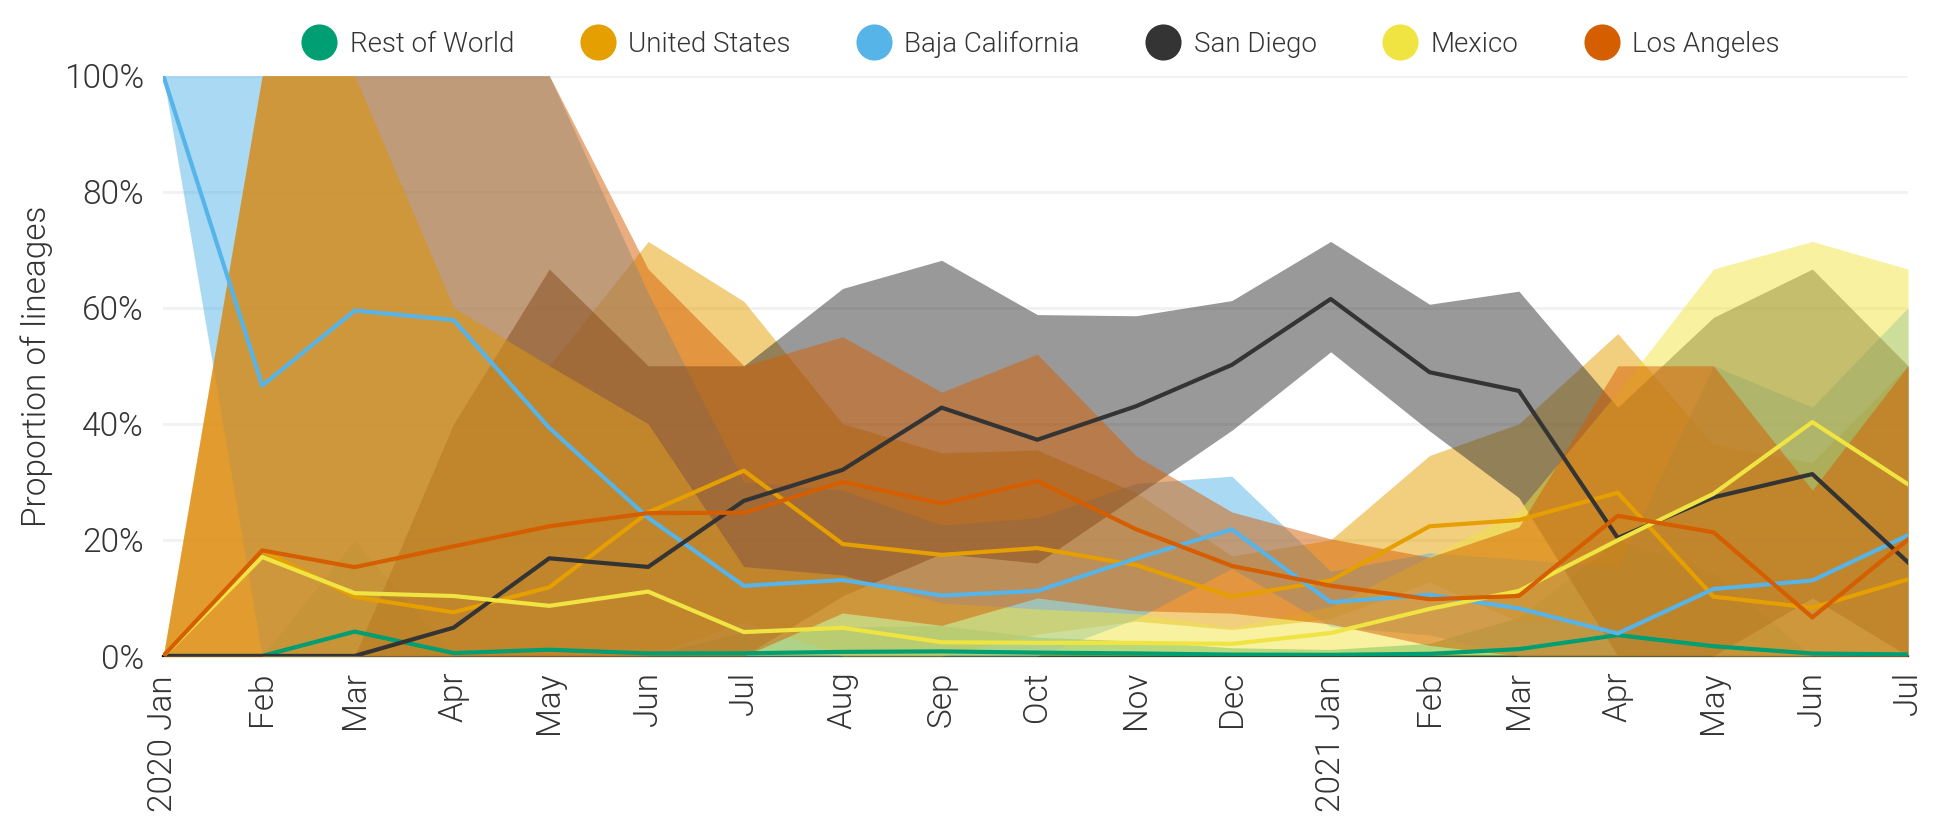

In [3]:
ps["anc_state"].unique()

color_dict = [
     ["Rest of World","#009E73"],
     ["United States","#E69F00"],
     ["Baja California","#56B4E9"],
     ["San Diego",COLOR],
     ["Mexico","#F0E442"],
     ["Los Angeles","#D55E00"]
]

leg = []
fig, ax = plt.subplots( dpi=200, figsize=(10,4.5) )
for loc, col in color_dict:
    plot_df = ps.loc[ps["anc_state"]==loc]
    ax.plot( "eval_time", "proportion", data=plot_df, color=col, zorder=9 )
    ax.fill_between( "eval_time", "hpdl", "hpdu", data=plot_df, color=col, alpha=0.5, zorder=8, linewidth=0 )
    leg.append( Line2D([0], [0], linestyle='none', marker='o', color=col, label=loc, markersize=12 ) )

ax.yaxis.set_major_formatter( PercentFormatter( 1, 0 ) )
basic_formatting(
    ax,
    spines=["bottom"],
    ylabel="Proportion of lineages",
    ylims=[0,1],
    xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2021-07-01")]
)
timeseries_formatting( ax )

ax.legend( handletextpad=0.1, handles=leg, frameon=False, fontsize=10, ncol=6, loc="upper center", bbox_to_anchor=(0,0,1,1.12) )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_lineage-persistence-san-diego.pdf" )
plt.show()

# Contact tracing Data
There are quite large uncertainties in the persistence results, owning to uncertainty in discrete state analysis. We confirm our results using contact tracing data collected by San Diego County, which asked, among other questions, whether there was travel within the US, Mexico, or internationally in the 14 days prior to symptom onset or positive test result (if infection is asymptomatic).

In [4]:
views = pd.read_csv( "../data/sdcphl_case_tracing.csv" )
dates = views["Year"] * 100 + views["Disease Week"]
views["week"] = pd.to_datetime( dates.astype(str) + "0", format='%Y%W%w' )
views["month"] = views["week"].astype( "datetime64[M]" )
views = views.drop( columns=["Year", "Disease Week"] )
views = views.rename( columns={"Total Number of Cases (Interviewed Only)" : "cases_interviewed"} )
#views = views.groupby( "month" ).sum()
views["percent_domestic"] = views["Domestic"] / views["cases_interviewed"]
views["percent_mexico"] = views["Mexico"] / views["cases_interviewed"]
views["percent_international"] = views["International"] / views["cases_interviewed"]
views["percent_travel"] = (views["Domestic"] + views["Mexico"] + views["International"]) / views["cases_interviewed"]

views = views.sort_index()
views

,Domestic,Mexico,International,cases_interviewed,week,month,percent_domestic,percent_mexico,percent_international,percent_travel
0,0,6,0,213,2020-06-14,2020-06-01,0.000000,0.028169,0.000000,0.028169
1,40,60,0,841,2020-06-21,2020-06-01,0.047562,0.071344,0.000000,0.118906
2,153,84,0,1511,2020-06-28,2020-06-01,0.101257,0.055592,0.000000,0.156850
3,270,85,1,2288,2020-07-05,2020-07-01,0.118007,0.037150,0.000437,0.155594
4,301,92,2,2606,2020-07-12,2020-07-01,0.115503,0.035303,0.000767,0.151573
...,...,...,...,...,...,...,...,...,...,...
58,286,69,15,1473,2021-07-18,2021-07-01,0.194162,0.046843,0.010183,0.251188
59,312,90,9,1878,2021-07-25,2021-07-01,0.166134,0.047923,0.004792,0.218850
60,296,72,12,1922,2021-08-01,2021-08-01,0.154006,0.037461,0.006243,0.197711
61,246,48,12,1656,2021-08-08,2021-08-01,0.148551,0.028986,0.007246,0.184783


In [6]:
def generate_list_from_values( entry ):
    entry_none = entry["cases_interviewed"] - entry["Domestic"] - entry["Mexico"] - entry["International"]
    return_list = (["Domestic"] * entry["Domestic"]) + (["Mexico"] * entry["Mexico"]) + (["International"] * entry["International"]) + (["None"] * entry_none)
    return return_list

get_low = lambda x: x.quantile( 0.025 )
get_high = lambda x: x.quantile( 0.975 )

test = views.iloc[2]
estimates = {
    "date" : [],
    "source" : [],
    "median" : [],
    "upper" : [],
    "lower" : [],
}
for _, row in views.iterrows():
    test_list = generate_list_from_values( row )
    results = []
    for i in range( 1000 ):
        boot_entry = np.random.choice( test_list, len( test_list ), replace=True )
        boot_results = pd.value_counts( boot_entry )
        boot_results = boot_results / boot_results.sum()
        results.append( boot_results )
    results = pd.DataFrame( results )

    for col in ["Domestic", "International", "Mexico" ]:
        estimates["date"].append( row["week"] )
        estimates["source"].append( col )
        if col in results:
            values = results.agg(
                value_median = ( col, "median" ),
                value_lower = ( col, get_low ),
                value_upper = ( col, get_high )
            )
            estimates["median"].append( values[col]["value_median" ])
            estimates["upper"].append( values[col]["value_upper" ])
            estimates["lower"].append( values[col]["value_lower" ])
        if col not in results:
            estimates["median"].append( 0 )
            estimates["upper"].append( 0 )
            estimates["lower"].append( 0 )
estimates = pd.DataFrame( estimates )
estimates.head()

,date,source,median,upper,lower
0,2020-06-14,Domestic,0.000000,0.000000,0.000000
1,2020-06-14,International,0.000000,0.000000,0.000000
2,2020-06-14,Mexico,0.028169,0.051643,0.009390
3,2020-06-21,Domestic,0.046373,0.063020,0.033294
4,2020-06-21,International,0.000000,0.000000,0.000000


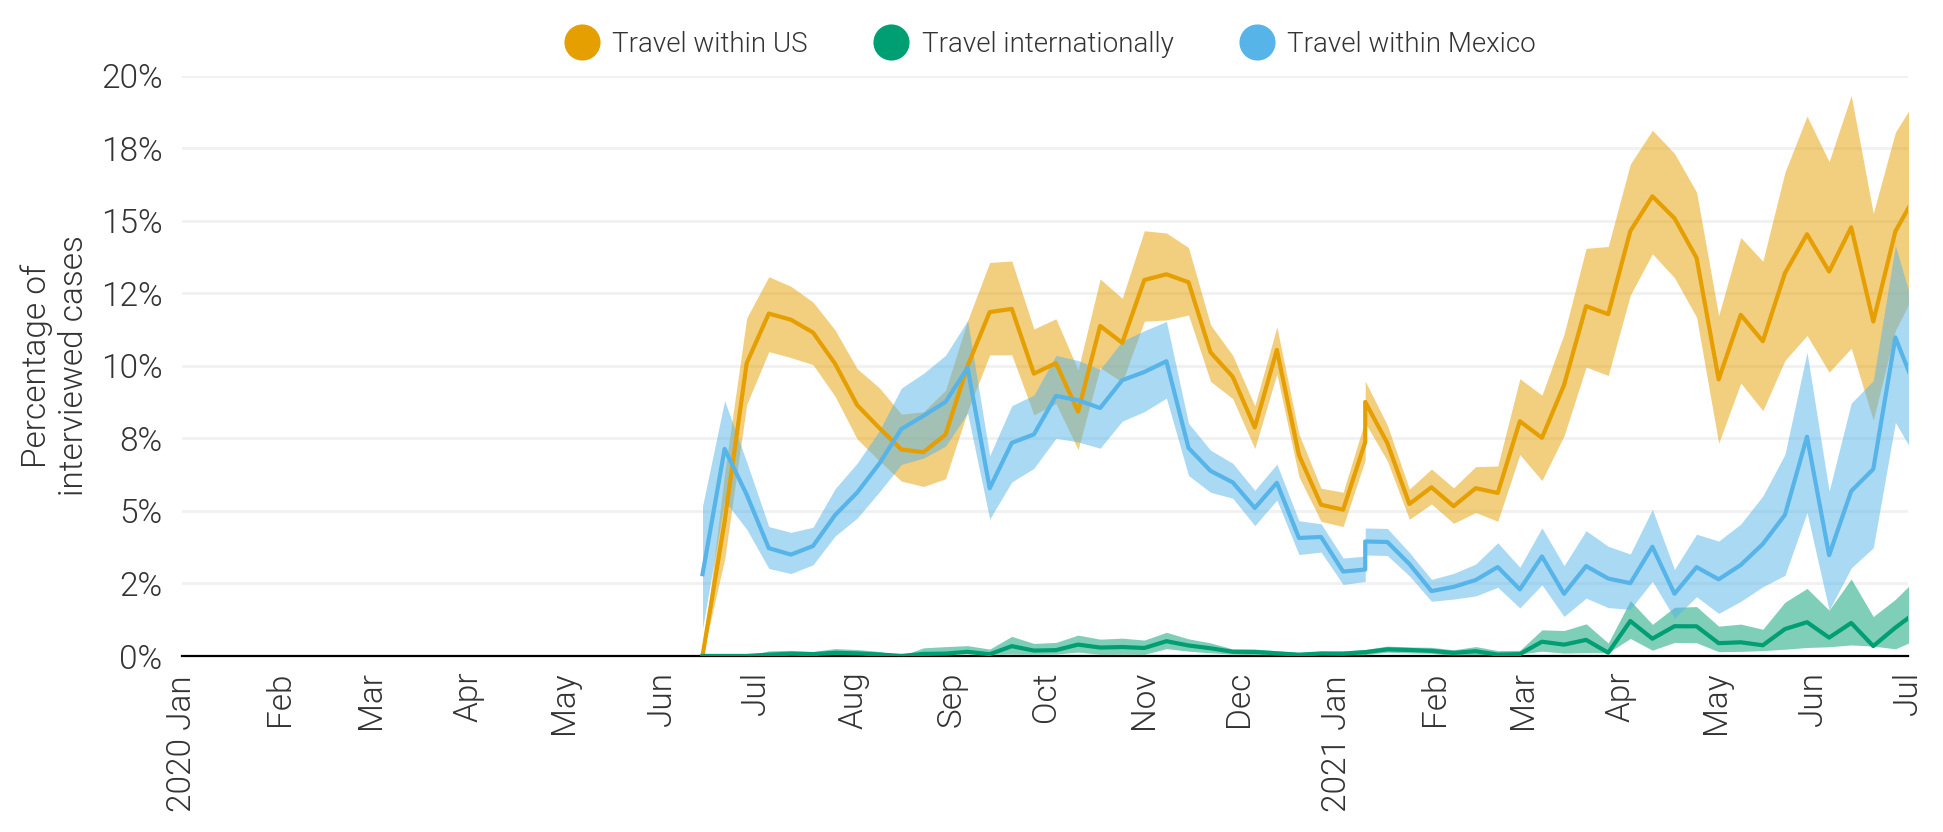

In [7]:
color_dict = [
    ["Domestic","#E69F00"],
    ["International","#009E73"],
    ["Mexico","#56B4E9"]
]

name_dic = {
    "International" : "Travel internationally",
    "Domestic" : "Travel within US",
    "Mexico" : "Travel within Mexico"
}

leg = []
fig, ax = plt.subplots( dpi=200, figsize=(10,4.5) )
for loc, col in color_dict:
    plot_df = estimates.loc[estimates["source"]==loc]
    ax.plot( "date", "median", data=plot_df, color=col, zorder=9 )
    ax.fill_between( "date", "upper", "lower", data=plot_df, color=col, alpha=0.5, zorder=8, linewidth=0 )
    leg.append( Line2D([0], [0], linestyle='none', marker='o', color=col, label=name_dic[loc], markersize=12 ) )

ax.yaxis.set_major_formatter( PercentFormatter( 1, 0 ) )
basic_formatting(
    ax,
    spines=["bottom"],
    ylabel="Percentage of\ninterviewed cases",
    ylims=[0,0.2],
    xlims=[pd.to_datetime("2020-01-01"), pd.to_datetime("2021-07-01")]
)
timeseries_formatting( ax )

ax.legend( handletextpad=0.1, handles=leg, frameon=False, fontsize=10, ncol=6, loc="upper center", bbox_to_anchor=(0,0,1,1.12) )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_contact-tracing-travel-san-diego.pdf" )
plt.show()

In [44]:
corr = views.merge( ps.loc[(ps["anc_state"]=="San Diego")&(ps["eval_state"]=="San Diego")], left_index=True, right_on=["eval_time"], how="left" )
corr = corr.loc[~corr["anc_state"].isna()]

X = corr["percent_travel"].to_numpy().reshape(-1, 1)
Y = corr["proportion"].to_numpy().reshape(-1, 1)

X2 = sm.add_constant( X )
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     5.856
Date:                Mon, 18 Jul 2022   Prob (F-statistic):             0.0323
Time:                        10:41:12   Log-Likelihood:                 11.174
No. Observations:                  14   AIC:                            -18.35
Df Residuals:                      12   BIC:                            -17.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6454      0.124      5.221      0.0

/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [118]:
corr = views.merge( ps.loc[(ps["anc_state"]=="Rest of World")&(ps["eval_state"]=="San Diego")], left_index=True, right_on=["eval_time"], how="left" )
corr = corr.loc[~corr["anc_state"].isna()]

X = corr["percent_international"].to_numpy().reshape(-1, 1)
Y = corr["proportion"].to_numpy().reshape(-1, 1)

X2 = sm.add_constant( X )
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

ValueError: You are trying to merge on int64 and datetime64[ns] columns. If you wish to proceed you should use pd.concat